In [111]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

The data used in this project is the women's clothing product reviews available to the public from the following S3 bucket:
`s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv` 
Let's download the data.
Note: This requires the AWS SDK to be installed and configured on the local machine if running locally. 

In [112]:
if 'data' not in os.listdir():
    os.mkdir("./data")
if "womens_clothing_ecommerce_reviews.csv" not in os.listdir("./data"):
    !aws s3 cp s3://dlai-practical-data-science/data/raw/womens_clothing_ecommerce_reviews.csv ./data

Now, let's explore the data and gain some information about it.

In [113]:
data = pd.read_csv("./data/womens_clothing_ecommerce_reviews.csv")
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [115]:
data.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


We will be using the `Review Text`  Column to generate the inputs for sentiment analysis and the `Rating` column to find the sentiment of eah review. 
Additionally, the `Class Name` column will be used to balance the dataset.
As a result, we only keep these columns for further analysis.

Also, since the names of these colmns are not easy to use prorammatically, the columns will be renamed to more proper names.
Products with lower than 10 reviews will also be removed as they don't have enough reviews to be inclluded

In [116]:
data_transformed =  data[["Review Text", "Rating", "Class Name"]].copy()
data_transformed.rename(columns = {"Review Text":'review', "Rating":"rating", "Class Name":"product_category"}, inplace = True)
data_transformed.dropna(inplace = True)

In [117]:
data_transformed.groupby("product_category").size()

product_category
Blouses           2983
Casual bottoms       1
Chemises             1
Dresses           6145
Fine gauge        1059
Intimates          147
Jackets            683
Jeans             1104
Knits             4626
Layering           132
Legwear            158
Lounge             669
Outerwear          319
Pants             1350
Shorts             304
Skirts             903
Sleep              214
Sweaters          1380
Swim               332
Trend              118
dtype: int64

Obciously, there is a significant imbalance between the number of reviews for different product categories, let' remove products that have less than 10 reviews to make the dataset a bit more balanced. 

In [118]:
data_transformed  = data_transformed.groupby("product_category").filter(lambda review: len(review) > 10)

We would like to use the data to train a sentiminet analyzer, the rating column could be used to assign a sentiment to each review.The following policy is used to assign a sentiment to each review:
- 1 <= rating <= 2 ==> Negative with a class value of 0 
- rating = 3 ==> Neutral with a class value of 1
- 3 < rating ==> Positive with a class value of -1 

In [119]:
def rating_to_sentiment(rating):
    if rating in {1, 2}:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

data_transformed["sentiment"] = data_transformed["rating"].apply(lambda rating: rating_to_sentiment(rating))

In [120]:
data_transformed.head()


,review,rating,product_category,sentiment
0,If this product was in petite i would get the...,4,Blouses,2
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,2
2,I had such high hopes for this dress and reall...,3,Dresses,1
3,I love love love this jumpsuit. it's fun fl...,5,Pants,2
4,This shirt is very flattering to all due to th...,5,Blouses,2


Since this is a classifier, the dataset should not be biased. The bias we are interested in could present itself in two ways:
- Number of reviews for each sentiment : We want the classifier to see the same number of reviews with different sentiments, if the model is trained on a dataset with more positive sentiments, then it might be overfitted to positive reviews and might not work well for neutral and negative reviews.
- Number of reviews for each product category : The balance in the number of reviews for each product category is also important. Product category has a significant impact on which words the classifier sees more and associates to the sentiments.

Let's have a look at how balanced the dataset is now.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


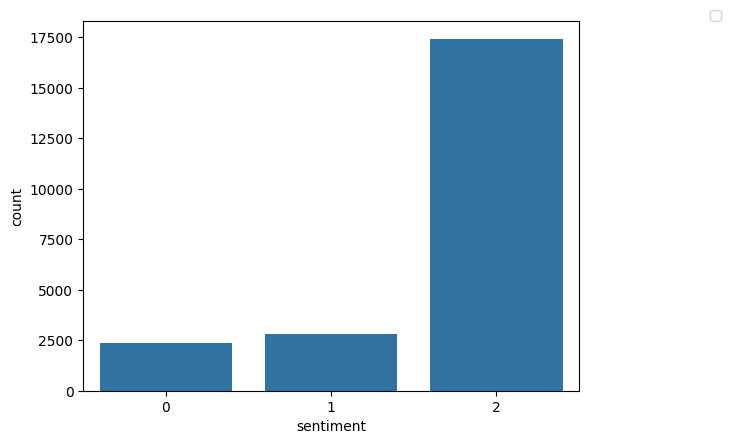

In [121]:
data_transformed_grouped = data_transformed.groupby(["sentiment"], as_index=False).size()
data_transformed_grouped.rename(columns = {"size":"count"}, inplace=True)
sns.barplot(x = data_transformed_grouped["sentiment"], y = data_transformed_grouped["count"]\
           )
plt.legend(bbox_to_anchor=(1.3, 1.05), loc='upper right')

In order to make the dataset more balanced, 

In [100]:
data_transformed_grouped["count"].min()
#data_transformed_balanced = data_transformed
len(data_transformed_grouped)

54

In [23]:
data_grouped.size()

Rating
1      842
2     1565
3     2871
4     5077
5    13131
dtype: int64